In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as stats

In [2]:
def calculate_biweight_bias(z_photo,z_spec,M):

# The biweight bias defined in HSC PDR2 paper. M stand for the median of z_photo. And this function can be
# iteratively applyed by replacing M with previous output of this function. We need to iterate this function
#till the incremental difference in the ouput reaches 0.1%.

    delz = (z_photo - z_spec)/(1+z_spec)
    z_mad = stats.median(abs(delz-M))
    u = (delz - M)/(6*z_mad)
    a = 0
    b = 0
    for i in range(len(u)):
        if abs(u[i]) < 1.0:
            a += (delz[i]-M)*(1-u[i]**2)**2
            b += (1-u[i]**2)**2
    
    bias_bw = M + a/b
    return bias_bw           

In [3]:
def calculate_biweight_scatter(z_photo,z_spec,M):

# The biweight scatter is also defined in HSC PDR2 paper, measuring how much the photo-z is scattered around 
# the true spec-z value. We simultaneously iterate the function with biweight bias by replacing M with b_bw.
    
    delz = (z_photo - z_spec)/(1+z_spec)
    z_mad = stats.median(abs(delz-M))
    u = (delz - M)/(9*z_mad)
    a = 0
    b = 0
    for i in range(len(u)):
        if abs(u[i]) < 1:
            a += ((delz[i]-M)**2)*(1-u[i]**2)**4
            b += (1-u[i]**2)*(1-5*u[i]**2)
    
    scatter_biweight = stats.sqrt(len(z_photo)*a)/abs(b)
    return scatter_biweight
    

In [4]:
def calculate_conv_outlier_rate(z_photo,z_spec):

# This function calculate the conventional outlier rate. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz)>0.15)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv

In [5]:
def calculate_biweight_outlier_rate(z_photo,z_spec,b_bw,sigma_bw):
    
# The biweight outlier rate defined in HSC DPR2 paper. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz-b_bw)>2*sigma_bw)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv
    
    

In [6]:
def calculate_loss_function(z_photo, z_spec):
    
# The loss function defined in HSC paper. 
    
    delz = (z_photo - z_spec)/(1+z_spec)
    L = 1-(1/(1+(delz/0.15)**2))
    
    return L

In [9]:
cd ../..

/mnt/data/HSC_v2


In [7]:
data_demp = pd.read_csv("/mnt/data/HSC_v2/HSC_demp_spectra.csv")

In [27]:
data_demp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60383 entries, 0 to 60382
Data columns (total 79 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   object_id_1                         60383 non-null  int64  
 1   object_id_isnull_1                  60383 non-null  bool   
 2   ra                                  60383 non-null  float64
 3   ra_isnull                           60383 non-null  bool   
 4   dec                                 60383 non-null  float64
 5   dec_isnull                          60383 non-null  bool   
 6   coord                               60383 non-null  object 
 7   coord_isnull                        60383 non-null  bool   
 8   skymap_id                           60383 non-null  int64  
 9   skymap_id_isnull                    60383 non-null  bool   
 10  g_cmodel_mag                        60383 non-null  float64
 11  g_cmodel_mag_isnull                 60383

In [8]:
specz = data_demp["specz_redshift"]
photoz_best = data_demp["photoz_best"]
photoz_mean = data_demp["photoz_mean"]
photoz_conf_best = data_demp["photoz_conf_best"]
photoz_conf_mean = data_demp["photoz_conf_mean"]

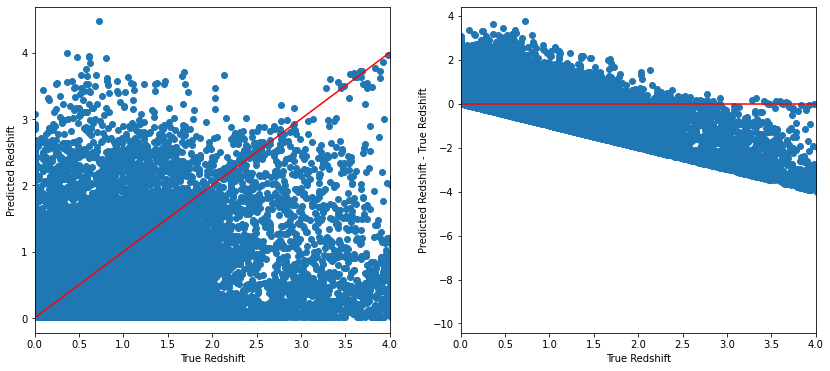

In [48]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(specz,photoz_best,'o')
plt.xlim(0,4)
plt.ylabel('Predicted Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,4], color='red')
plt.subplot(1,2,2)
plt.plot(specz,photoz_best-specz,'o')
plt.xlim(0,4)
plt.ylabel('Predicted Redshift - True Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,0], color='red')

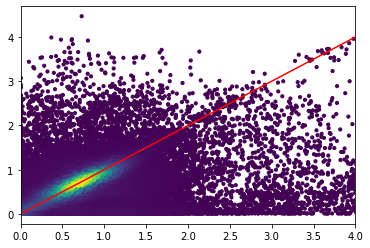

In [49]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([specz,photoz_best])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(specz, photoz_best, c=z, s=10)
plt.plot([0,4], [0,4], color='red')
plt.xlim(0,4)
plt.show()

In [61]:
delz = (photoz_best - specz)/(1+specz)
z_median = stats.median(delz)
b_bw = calculate_biweight_bias(photoz_best,specz,z_median)
sigma_bw = calculate_biweight_scatter(photoz_best,specz,z_median)
outlier_rate = calculate_biweight_outlier_rate(photoz_best,specz,b_bw,sigma_bw)
loss_function = calculate_loss_function(photoz_best,specz)

diff = z_median=b_bw

while diff > 0.001:
    b_bw_new = calculate_biweight_bias(photoz_best,specz,b_bw)
    sigma_bw = calculate_biweight_scatter(photoz_best,specz,b_bw_new)
    outlier_rate = calculate_biweight_outlier_rate(photoz_best,specz,b_bw_new,sigma_bw)
    diff = b_bw -b_bw_new
    b_bw = b_bw_new

average_loss = sum(loss_function)/len(loss_function)

print (b_bw)
print(sigma_bw)
print(outlier_rate)
print(average_loss)

-0.0029348280416878017
0.059124920625193214
0.27963168441448755
0.2575798689663788


In [38]:
print ("Zphot           bias     sigma_bw     outlier_rate_bw     <L(delz)>")
for i in range(20):
    index = np.intersect1d(np.where(photoz_best>=0.2*i)[0],np.where(photoz_best<0.2*i+0.2)[0])
    photoz_best_filtered = np.asarray(photoz_best[index])
    specz_filtered= np.asarray(specz[index])
    
    delz_filtered = (photoz_best_filtered - specz_filtered)/(1+specz_filtered)
    z_median_filtered = stats.median(delz_filtered)
    
    b_bw = calculate_biweight_bias(photoz_best_filtered,specz_filtered,z_median_filtered)
    sigma_bw = calculate_biweight_scatter(photoz_best_filtered,specz_filtered,z_median_filtered)
    outlier_rate = calculate_biweight_outlier_rate(photoz_best_filtered,specz_filtered,b_bw,sigma_bw)
    loss_function = calculate_loss_function(photoz_best_filtered,specz_filtered)

    diff = z_median=b_bw

    while diff > 0.001:
        b_bw_new = calculate_biweight_bias(photoz_best_filtered,specz_filtered,b_bw)
        sigma_bw = calculate_biweight_scatter(photoz_best_filtered,specz_filtered,b_bw_new)
        outlier_rate = calculate_biweight_outlier_rate(photoz_best_filtered,specz_filtered,b_bw_new,sigma_bw)
        diff = b_bw -b_bw_new
        b_bw = b_bw_new

    average_loss = sum(loss_function)/len(loss_function)
    
    print ("%.2f - %.2f   %+f   %.3f            %.3f         %.3f"%(0.2*i,round(0.2*i+0.2,2),round(b_bw,3),round(sigma_bw,3),round(outlier_rate,3),round(average_loss,3)))

Zphot           bias     sigma_bw     outlier_rate_bw     <L(delz)>
0.00 - 0.20   -0.127000   0.336            0.028         0.460
0.20 - 0.40   -0.039000   0.169            0.157         0.361
0.40 - 0.60   -0.010000   0.062            0.235         0.226
0.60 - 0.80   -0.000000   0.032            0.209         0.136
0.80 - 1.00   -0.004000   0.038            0.212         0.153
1.00 - 1.20   +0.001000   0.067            0.270         0.261
1.20 - 1.40   +0.027000   0.210            0.206         0.413
1.40 - 1.60   +0.101000   0.387            0.095         0.531
1.60 - 1.80   +0.077000   0.373            0.117         0.531
1.80 - 2.00   +0.174000   0.510            0.112         0.612
2.00 - 2.20   +0.345000   0.577            0.066         0.665
2.20 - 2.40   +0.485000   0.664            0.058         0.744
2.40 - 2.60   +0.615000   0.750            0.071         0.740
2.60 - 2.80   +0.614000   0.781            0.081         0.750
2.80 - 3.00   +0.807000   0.852            0.049  